# CNN Training

Target of this code is to train a CNN network to extract the needle position of an analog needle device.

### Preparing the training
* First all libraries are loaded
    * It is assumed, that they are installed during the Python setup
* matplotlib is set to print the output inline in the jupyter notebook

In [1]:
import os
import matplotlib.pyplot as plt
import glob
from PIL import Image
import numpy as np
from sklearn.utils import shuffle
from tensorflow.python import keras
from tensorflow.python.keras import Sequential
from tensorflow.python.keras.layers import Dense, InputLayer, Conv2D, MaxPool2D, Flatten, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import keras.backend as K
from keras.callbacks import History 

loss_ges = np.array([])
val_loss_ges = np.array([])

%matplotlib inline
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

Using TensorFlow backend.


### Load training data
* The data is expected in the "Input_dir"
* Picture size must be 32x32 with 3 color channels (RGB)
* The filename contains the informations needed for training:
* Typical filename: 
    * ReadOut-xx_Watch-y_zzzz.jpg 
    * e.g. "ReadOut-54_Watch-4_1667.jpg"

|Place holder | Meaning                     | Usage        |
|------------- |-----------------------------|--------------|
| **xx**          | readout value               | **to be learned** |
| y           | different analog watches    | ignored      |
| zzzz        | running number              | not needed   |

* The images are stored in the x_data[]
* The expected output for each image in the corresponding y_data[]

* The last step is a shuffle (from sklearn.utils) as the filenames are on order due to the encoding of the expected analog readout in the filename 

In [2]:
Input_dir='data_resize_all'

files = glob.glob(Input_dir + '/*.*')
x_data = []
y_data = []

for aktfile in files:
    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    test_image = np.reshape(test_image, (32,32,3))
    base = os.path.basename(aktfile)
    zahl = (int(base[8:10])) / 100
    x_data.append(test_image)
    zw = np.array([zahl])
    y_data.append(zw)

x_data = np.array(x_data)
y_data = np.array(y_data)
print(x_data.shape)
print(y_data.shape)

x_data, y_data = shuffle(x_data, y_data)
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)

(2883, 32, 32, 3)
(2883, 1)


### Define the model

The layout of the network ist a typcial CNN network with alternating **Conv2D** and **MaxPool2D** layers. Finished after **flattening** with additional **Dense** layer.

#### Important
* Shape of the input layer: (32, 32, 3)
* Shape of the output layer: (1)

### Custom Loss
A custom loss function is mirroring the predicted value to "+1" and giving back the minimum value of both options (dif1, dif2)

In [3]:
model = Sequential()
model.add(BatchNormalization(input_shape=(32,32,3)))
model.add(Conv2D(64, (5, 5), input_shape=(32,32,3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(4,4)))
model.add(Conv2D(32, (5, 5), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(4,4)))
model.add(Conv2D(32, (3, 3), padding='same', activation="relu"))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(16,activation="linear"))
model.add(Dense(1))
model.summary()

def Periodic_Loss(y_true, y_pred):
    dif1 = K.abs(y_pred - y_true)
    dif2 = K.abs(dif1 + K.constant(1))
    dif = K.minimum(dif1, dif2)
    ret = K.mean(K.square(dif), axis=-1)
    return ret

model.compile(loss=Periodic_Loss, optimizer=keras.optimizers.Adadelta(), metrics = ["accuracy"])
#model.compile(loss=keras.losses.mean_squared_error, optimizer=keras.optimizers.Adadelta(), metrics = ["accuracy"])

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_v1 (Batc (None, 32, 32, 3)         12        
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 32)          51232     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 2, 2, 32)          9248      
_________________________________________________________________
max_

# Training
The input pictures are randomly scattered for brightness and pixel shift variations. These is implemented with a ImageDataGenerator.


The training is splitted into two steps:
1. Variation of the brightness only
2. Variation of brightness and Pixel Shift

### Step 1: Brigthness scattering only

In [4]:
Batch_Size = 8
Epoch_Anz = 20
Shift_Range = 0
Brightness_Range = 0.3

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], height_shift_range=[-Shift_Range,Shift_Range],brightness_range=[1-Brightness_Range,1+Brightness_Range])

train_iterator = datagen.flow(X_train, y_train, batch_size=Batch_Size)
validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)

history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
289/289 [==============================] - 10s 36ms/step - loss: 0.0491 - acc: 0.0022 - val_loss: 0.0044 - val_acc: 0.0000e+00
Epoch 2/20
289/289 [==============================] - 9s 31ms/step - loss: 0.0105 - acc: 0.0030 - val_loss: 0.0030 - val_acc: 0.0017
Epoch 3/20
289/289 [==============================] - 9s 31ms/step - loss: 0.0059 - acc: 0.0039 - val_loss: 0.0094 - val_acc: 0.0000e+00
Epoch 4/20
289/289 [==============================] - 9s 32ms/step - loss: 0.0030 - acc: 0.0043 - val_loss: 0.0018 - val_acc: 0.0017
Epoch 5/20
289/289 [==============================] - 9s 32ms/step - loss: 0.0028 - acc: 0.0043 - val_loss: 0.0080 - val_acc: 0.0017
Epoch 6/20
289/289 [==============================] - 9s 33ms/step - loss: 0.0021 - acc: 0.0043 - val_loss: 4.4400e-04 - val_acc: 0.0017
Epoch 7/20
289/289 [==============================] - 9s 32ms/step - loss: 0.0013 - acc: 0.0048 - val_loss: 0.0011 - val_acc: 0.0000e+00
Epoc

### Step 1: Learing result
 
* Visualization of the training and validation results

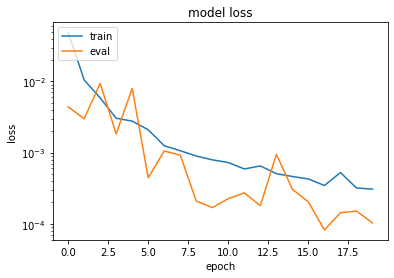

In [5]:
loss_ges = np.append(loss_ges, history.history['loss'])
val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])

plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Step 2: Brigthness and Pixel Shift scattering
Here a higher number of epochs is used to reach the minimum loss function

In [6]:
Batch_Size = 8
Epoch_Anz = 40
Shift_Range = 1
Brightness_Range = 0.3

datagen = ImageDataGenerator(width_shift_range=[-Shift_Range,Shift_Range], height_shift_range=[-Shift_Range,Shift_Range],brightness_range=[1-Brightness_Range,1+Brightness_Range])

train_iterator = datagen.flow(X_train, y_train, batch_size=Batch_Size)
validation_iterator = datagen.flow(X_test, y_test, batch_size=Batch_Size)

history = model.fit_generator(train_iterator, validation_data = validation_iterator, epochs = Epoch_Anz)

Epoch 1/40
289/289 [==============================] - 10s 36ms/step - loss: 0.0037 - acc: 0.0043 - val_loss: 5.4468e-04 - val_acc: 0.0017
Epoch 2/40
289/289 [==============================] - 10s 35ms/step - loss: 0.0021 - acc: 0.0039 - val_loss: 4.7420e-04 - val_acc: 0.0017
Epoch 3/40
289/289 [==============================] - 10s 36ms/step - loss: 0.0020 - acc: 0.0035 - val_loss: 8.6913e-04 - val_acc: 0.0017
Epoch 4/40
289/289 [==============================] - 10s 35ms/step - loss: 0.0015 - acc: 0.0048 - val_loss: 5.1330e-04 - val_acc: 0.0017
Epoch 5/40
289/289 [==============================] - 10s 35ms/step - loss: 8.6363e-04 - acc: 0.0043 - val_loss: 0.0021 - val_acc: 0.0017
Epoch 6/40
289/289 [==============================] - 10s 35ms/step - loss: 6.2187e-04 - acc: 0.0048 - val_loss: 2.7489e-04 - val_acc: 0.0017
Epoch 7/40
289/289 [==============================] - 10s 36ms/step - loss: 7.6957e-04 - acc: 0.0048 - val_loss: 0.0019 - val_acc: 0.0017
Epoch 8/40
289/289 [==========

Epoch 37/40
289/289 [==============================] - 10s 36ms/step - loss: 1.4492e-04 - acc: 0.0052 - val_loss: 8.0769e-05 - val_acc: 0.0017
Epoch 38/40
289/289 [==============================] - 10s 36ms/step - loss: 1.6084e-04 - acc: 0.0052 - val_loss: 2.9455e-04 - val_acc: 0.0017
Epoch 39/40
289/289 [==============================] - 11s 37ms/step - loss: 1.9993e-04 - acc: 0.0052 - val_loss: 2.3424e-04 - val_acc: 0.0017
Epoch 40/40
289/289 [==============================] - 11s 36ms/step - loss: 1.8121e-04 - acc: 0.0052 - val_loss: 5.7710e-05 - val_acc: 0.0017


### Step 2: Learing result
 
* Visualization of the training and validation results

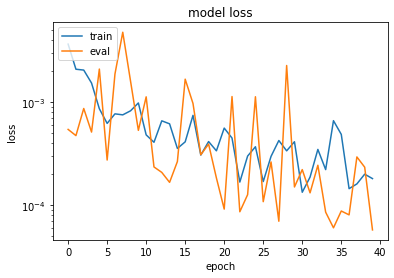

In [7]:
loss_ges = np.append(loss_ges, history.history['loss'])
val_loss_ges = np.append(val_loss_ges, history.history['val_loss'])

plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.show()

### Overall Learing results (Step 1 & Step 2)

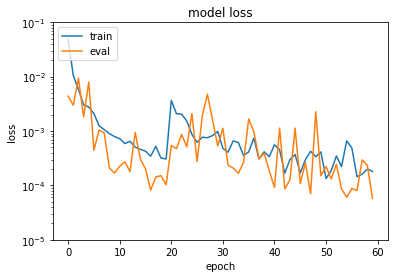

In [8]:
plt.semilogy(loss_ges)
plt.semilogy(val_loss_ges)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','eval'], loc='upper left')
plt.ylim(1E-1, 1E-5)
plt.show()

### Check the model by hand

* The following code uses the trained model to check the deviation for each picture.
* The evaluation takes the periodic character of the results into account.

In [9]:
Input_dir='data_resize_all'
files = glob.glob(Input_dir + '/*.*')
res = []

for aktfile in files:
    base = os.path.basename(aktfile)
    zahl = (int(base[8:10])) / 100
    test_image = Image.open(aktfile)
    test_image = np.array(test_image, dtype="float32")
    img = np.reshape(test_image,[1,32,32,3])
    classes = model.predict(img)
    zw1 = zahl
    zw2 = round(classes[0][0], 2)
    zw3 = round(classes[0][0] - zahl, 2)
    zw4a = abs(zw3)
    zw4b = abs(zw3+1)
    zw4c = abs(zw3-1)
    zw4 = zw3
    if zw4b < zw4a: 
        zw4 = zw3+1
        zw4a = zw4b
    if zw4c < zw4a: 
        zw4 = zw3-1
    res.append(np.array([zw1, zw2, zw3, zw4]))
#    print(base, ', ', zw1, ', ', round(zw2, 2), ', ', round(zw3, 2), ', ', round(zw4, 2))

res = np.asarray(res)
statistic = np.array([np.mean(res[:,3]), np.std(res[:,3]), np.min(res[:,3]), np.max(res[:,3])])
print(statistic)
res_step_1 = res

[ 0.0003  0.0135 -0.46    0.03  ]


### Plotting of real and model values:

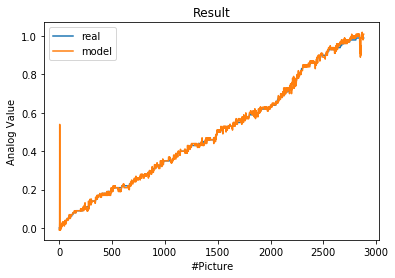

In [10]:
plt.plot(res[:,0])
plt.plot(res[:,1])
plt.title('Result')
plt.ylabel('Analog Value')
plt.xlabel('#Picture')
plt.legend(['real','model'], loc='upper left')
plt.show()

### Deviation between real and model values
Taking the periodic structure into account (e.g. deviation of 0.8 is 0.2)

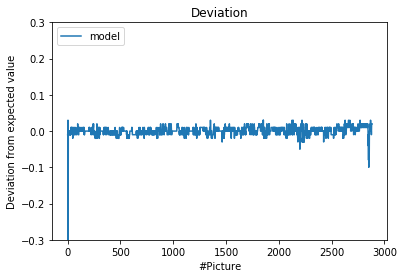

In [11]:
plt.plot(res[:,3])
plt.title('Deviation')
plt.ylabel('Deviation from expected value')
plt.xlabel('#Picture')
plt.legend(['model'], loc='upper left')
plt.ylim(-0.3, 0.3)
plt.show()

### Save the model

* Save the model to the file with the "h5" file format

In [12]:
model.save("Train_CNN_Version1_Analog-Readout.h5")